In [1]:
CURRENT_MODEL = 'ENSEMBLE'
TRAINING = False
OVER_FIT = False
if CURRENT_MODEL == 'BNN':
    MODEL_FILE = './models/best_BNN_model'
elif CURRENT_MODEL == 'ENSEMBLE':
    MODEL_FILE = './models/best_model'
    if OVER_FIT:
        MODEL_FILE = './models/best_overfit_model'

In [2]:

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
# Import necessary libraries
from keras.datasets import cifar10
import numpy as np
from sklearn.utils import resample

dataset = datasets.cifar10.load_data()

# Turn it into a binary classification problem by making it frogs or not frogs
(train_images, train_labels), (test_images, test_labels) = dataset

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Separate frog and not frog images
frog_indices = np.where(train_labels == 6)[0]
not_frog_indices = np.where(train_labels != 6)[0]

# Downsample majority (not frog)
not_frog_downsampled = resample(not_frog_indices,
                                replace=False, # sample without replacement
                                n_samples=len(frog_indices), # match minority n
                                random_state=27) # reproducible results

# Combine minority and downsampled majority
downsampled_indices = np.concatenate([frog_indices, not_frog_downsampled])

# Downsampled feature and label sets
train_images_downsampled = train_images[downsampled_indices]
train_labels_downsampled = train_labels[downsampled_indices]
train_labels_downsampled = np.where(train_labels_downsampled == 6, 1, 0)
test_labels = np.where(test_labels == 6, 1, 0)

train_images = train_images_downsampled
train_labels = train_labels_downsampled


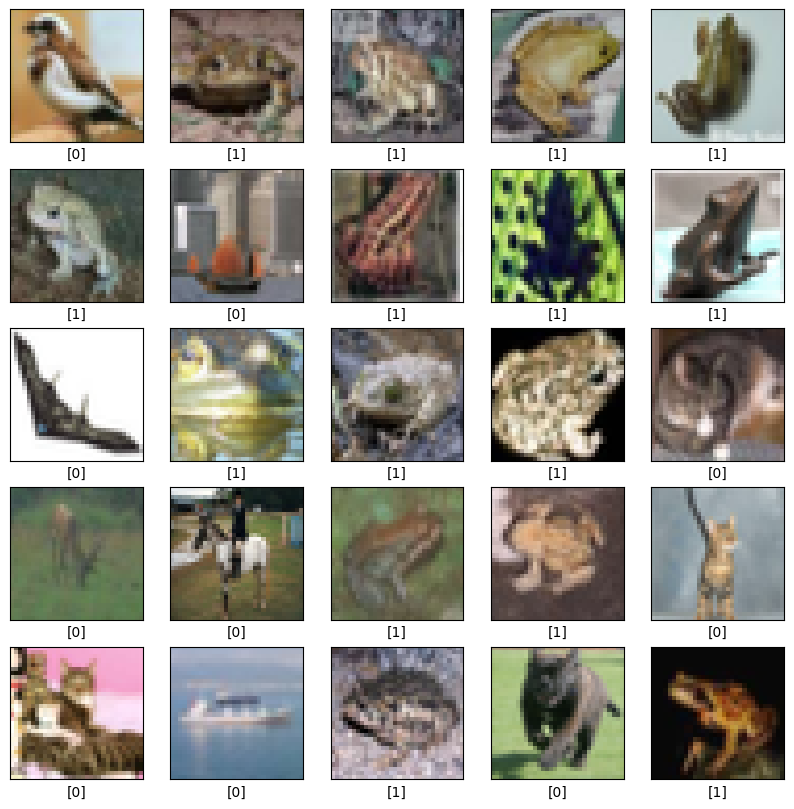

In [4]:
class_names = ['not_frog', 'frog']

randomly_chosen_indexes = np.random.uniform(0, len(train_images), 25).astype(int)
plt.figure(figsize=(10,10))
for i, value in enumerate(randomly_chosen_indexes):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[value])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(train_labels[value])
plt.show()

In [5]:
import pandas as pd

# Flatten the 3D array to 1D
flattened_train_labels = train_labels.flatten()
flattened_test_labels = test_labels.flatten()

print('train:', pd.DataFrame(flattened_train_labels).describe())
print('test:', pd.DataFrame(flattened_test_labels).describe())

# Use the describe function

train:                   0
count  10000.000000
mean       0.500000
std        0.500025
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
test:                   0
count  10000.000000
mean       0.100000
std        0.300015
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


### Compile and train the model

In [6]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



history_list = {}

history_dict_base = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

history_dict = {}

ENSEMBLE_SIZE = 20
if CURRENT_MODEL == 'BNN':
    ENSEMBLE_SIZE = 1
    

for i in range(ENSEMBLE_SIZE): 
    history_dict[i] = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
    }

    history_list[i] = []

print(history_dict)



{0: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 1: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 2: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 3: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 4: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 5: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 6: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 7: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 8: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 9: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 10: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 11: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 12: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 13: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}, 14: {'accuracy': [], 'val_acc

In [7]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model

# Function to set dropout rate
def set_dropout_rate(model, new_rate):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.rate = new_rate


def create_dropout_model(dropout_rate=0.5):
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model
  

In [8]:
 
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model

def create_model():
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [9]:
if CURRENT_MODEL == 'BNN' and TRAINING:
    for i in range(ENSEMBLE_SIZE):

        # Define the early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)

        # Define the model checkpoint callback
        model_checkpoint = ModelCheckpoint(f'{MODEL_FILE}_{i}.keras', monitor='val_loss', save_best_only=True)

        model = create_dropout_model()
        
        model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')])
        set_dropout_rate(model, np.nextafter(np.float32(0), np.float32(1)))

        X_train_subset, y_train_subset = resample(train_images, train_labels)

        history = model.fit(X_train_subset, y_train_subset, epochs=100,
                            validation_data=(test_images, test_labels),
                            callbacks=[early_stopping, model_checkpoint])

        set_dropout_rate(model, 0.5)

        history_list[i].append(history)

        for history in history_list[i]:
            for key in history_dict_base.keys():
                history_dict[i][key].extend(history.history[key])
elif (CURRENT_MODEL == 'ENSEMBLE' and TRAINING): 
    for i in range(ENSEMBLE_SIZE):

        # Define the early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)

        # Define the model checkpoint callback
        model_checkpoint = ModelCheckpoint(f'{MODEL_FILE}_{i}.keras', monitor='val_loss', save_best_only=True)

        model = create_model()
        
        model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')])


        X_train_subset, y_train_subset = resample(train_images, train_labels)

        history = model.fit(X_train_subset, y_train_subset, epochs=100,
                            validation_data=(test_images, test_labels),
                            callbacks=[early_stopping, model_checkpoint])

        history_list[i].append(history)

        for history in history_list[i]:
            for key in history_dict_base.keys():
                history_dict[i][key].extend(history.history[key])

In [10]:
if CURRENT_MODEL == 'BNN':
    import numpy as np
    from tensorflow.keras.models import load_model

    class MCDropoutModel:
        def __init__(self, base_model, num_predictions=100, dropout_rate=0.5):
            self.base_model = base_model
            self.num_predictions = num_predictions
            self.dropout_rate = dropout_rate

        def verbose_predict(self, inputs):
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for _ in range(self.num_predictions):
                # Enable dropout during prediction
                outputs.append(self.base_model(inputs, training=True))

            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack

    loaded_model = load_model(f'{MODEL_FILE}_0.keras')

    # Wrap the base model with the MCDropoutModel
    model_under_test = MCDropoutModel(loaded_model, num_predictions=20)

In [11]:

# set_dropout_rate(loaded_model, 0.5)
# model_with_two_predictions = MCDropoutModel(loaded_model, num_predictions=2)

# predictions = model_with_two_predictions.verbose_predict(test_images[:4])

In [12]:
if CURRENT_MODEL == 'ENSEMBLE':
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Average
    from tensorflow.keras.models import load_model


    class EnsembleModel(tf.keras.Model):
        def __init__(self, models, **kwargs):
            super(EnsembleModel, self).__init__(**kwargs)
            self.models = models

        def call(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Average the outputs of each model
            # First, stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            # Then, calculate the mean along the first axis
            outputs_mean = tf.reduce_mean(outputs_stack, axis=0)

            return outputs_mean
        
        def verbose_predict(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack


    model_list = []

    for i in range(ENSEMBLE_SIZE): 
        ensemble_member = load_model(f"{MODEL_FILE}_{i}.keras")
        ensemble_member.evaluate(test_images, test_labels)
        model_list.append(ensemble_member)


    # Create the ensemble model
    model_under_test = EnsembleModel(model_list)

    # Compile the ensemble model
    model_under_test.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

    # model_under_test(test_images)

    # Evaluate the ensemble model
    performance = model_under_test.evaluate(test_images, test_labels)
    print(performance)
    # print('Ensemble accuracy:', accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9097 - auc_1: 0.9508 - loss: 0.2184
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8693 - auc_2: 0.9496 - loss: 0.3042
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8923 - auc_3: 0.9440 - loss: 0.2648
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9282 - auc_4: 0.9321 - loss: 0.2081
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8733 - auc_5: 0.9552 - loss: 0.3021
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8837 - auc_6: 0.9440 - loss: 0.2763
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9125 - auc_7: 0.9517 - loss: 0.2197
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9145 - auc_8: 0.9493 - loss: 0.2138
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8994 - auc_9: 0.9457 - loss: 0.2368
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8974 - auc_10: 0.9498 - loss: 0.2442
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9132 - auc_11: 0.9535 - loss: 0.20

313/313 - 1s - 3ms/step - accuracy: 0.9124 - auc_1: 0.9486 - loss: 0.2148
313/313 - 1s - 4ms/step - accuracy: 0.8651 - auc_2: 0.9462 - loss: 0.3077
313/313 - 1s - 4ms/step - accuracy: 0.8918 - auc_3: 0.9411 - loss: 0.2666
313/313 - 1s - 4ms/step - accuracy: 0.9312 - auc_4: 0.9286 - loss: 0.2092
313/313 - 1s - 3ms/step - accuracy: 0.8744 - auc_5: 0.9507 - loss: 0.2971
313/313 - 1s - 3ms/step - accuracy: 0.8824 - auc_6: 0.9400 - loss: 0.2778
313/313 - 1s - 3ms/step - accuracy: 0.9115 - auc_7: 0.9469 - loss: 0.2216
313/313 - 1s - 3ms/step - accuracy: 0.9159 - auc_8: 0.9466 - loss: 0.2113
313/313 - 1s - 3ms/step - accuracy: 0.8995 - auc_9: 0.9420 - loss: 0.2353
313/313 - 1s - 3ms/step - accuracy: 0.8962 - auc_10: 0.9499 - loss: 0.2441
313/313 - 1s - 3ms/step - accuracy: 0.9124 - auc_11: 0.9495 - loss: 0.2080
313/313 - 1s - 3ms/step - accuracy: 0.8928 - auc_12: 0.9457 - loss: 0.2450
313/313 - 1s - 3ms/step - accuracy: 0.9212 - auc_13: 0.9417 - loss: 0.1949
313/313 - 1s - 3ms/step - accuracy

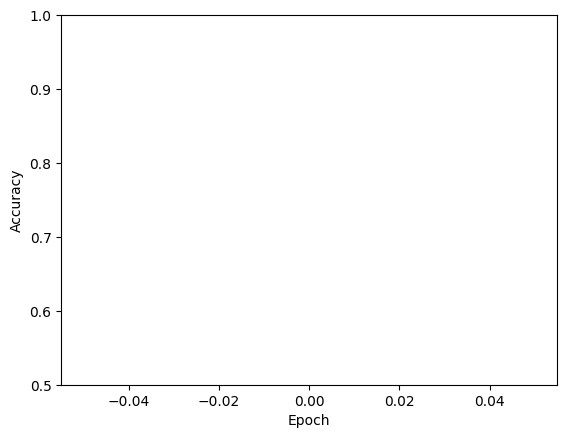

In [13]:


for i in range(ENSEMBLE_SIZE):
    model = load_model(f'{MODEL_FILE}_{i}.keras')
    plt.plot(history_dict[i]['accuracy'], label=f'accuracy {i}')
    plt.plot(history_dict[i]['val_accuracy'], label = f'val_accuracy {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])

    test_loss, test_acc, test_auc = model.evaluate(test_images,  test_labels, verbose=2)

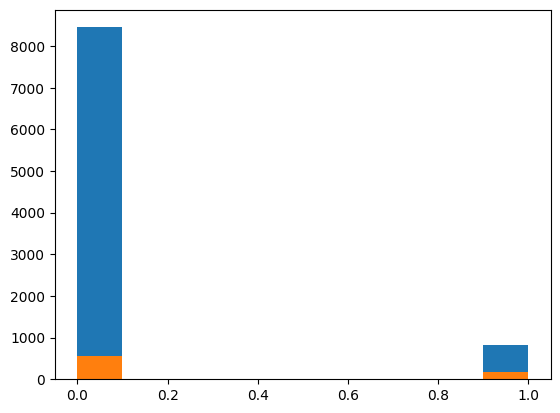

In [14]:
outputs_stack = model_under_test.verbose_predict(test_images)
outputs_mean = tf.reduce_mean(outputs_stack, axis=0)
ensemble_predictions = np.where(outputs_mean > 0.5, 1, 0)
individual_predictions = np.where(outputs_stack > 0.5, 1, 0)


# Separate the correct and incorrect predictions
correct_prediction_indices = np.where(ensemble_predictions == test_labels)[0]
incorrect_prediction_indices = np.where(ensemble_predictions != test_labels)[0]
correct_predictions = test_labels[correct_prediction_indices]
incorrect_predictions = test_labels[incorrect_prediction_indices]
plt.hist(correct_predictions)
plt.hist(incorrect_predictions)


positive_label_indices = np.where(test_labels == 1)[0]
negative_label_indices = np.where(test_labels == 0)[0]

true_positive_indices = np.intersect1d(positive_label_indices, correct_prediction_indices)
true_negative_indices = np.intersect1d(negative_label_indices, correct_prediction_indices)

false_negative_indices = np.intersect1d(positive_label_indices, incorrect_prediction_indices)
false_positive_indices = np.intersect1d(negative_label_indices, incorrect_prediction_indices)


In [15]:
# for i in range(100):
#     tn = true_negative_indices[i]
#     print(f'tn: ensemble_predictions: {ensemble_predictions[tn]}, label: {test_labels[tn]}')

# for i in range(100):
#     fp = false_positive_indices[i]
#     print(f'fp: ensemble_predictions: {ensemble_predictions[fp]}, label: {test_labels[fp]}')


# for i in range(100):
#     fn = false_negative_indices[i]
#     print(f'fn: ensemble_predictions: {ensemble_predictions[fn]}, label: {test_labels[fn]}')


# for i in range(100):
#     tp = true_positive_indices[i]
#     print(f'tp: ensemble_predictions: {ensemble_predictions[tp]}, label: {test_labels[tp]}')


# true_positives = np.random.choice(true_positive_indices, 16, replace=False)

# for i in true_positives:
#     print(f'fp: softpred: {outputs_mean[i]} ensemble_predictions: {ensemble_predictions[i]}, label: {test_labels[i]}')

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate variance and mean of outputs
output_variance = np.var(outputs_stack, axis=0)
outputs_mean = np.mean(outputs_stack, axis=0)

# Calculate confidence
output_confidence = np.abs(outputs_mean - 0.5)

# Using np.take to filter arrays based on indices
var_correct = np.take(output_variance, correct_prediction_indices)
var_incorrect = np.take(output_variance, incorrect_prediction_indices)

conf_correct = np.take(output_confidence, correct_prediction_indices)
conf_incorrect = np.take(output_confidence, incorrect_prediction_indices)

output_correct = np.take(outputs_mean, correct_prediction_indices)
output_incorrect = np.take(outputs_mean, incorrect_prediction_indices)

var_tp = np.take(output_variance, true_positive_indices)
var_fp = np.take(output_variance, false_positive_indices)
var_tn = np.take(output_variance, true_negative_indices)
var_fn = np.take(output_variance, false_negative_indices)

conf_tp = np.take(output_confidence, true_positive_indices)
conf_fp = np.take(output_confidence, false_positive_indices)
conf_tn = np.take(output_confidence, true_negative_indices)
conf_fn = np.take(output_confidence, false_negative_indices)


In [28]:

prediction_outcome = np.where(ensemble_predictions != test_labels, 0, 1)
np_df = np.hstack((output_confidence, output_variance, prediction_outcome, outputs_mean, test_labels))


df = pd.DataFrame(np_df, columns=['confidence', 'variance', 'outcome', 'mean', 'label'])
df['tp'] = df.apply(lambda row: int(row['label'] == 1 and row['outcome'] == 1), axis=1)
df['fp'] = df.apply(lambda row: int(row['label'] == 1 and row['outcome'] == 0), axis=1)
df['tn'] = df.apply(lambda row: int(row['label'] == 0 and row['outcome'] == 1), axis=1)
df['fn'] = df.apply(lambda row: int(row['label'] == 0 and row['outcome'] == 0), axis=1)

df.head()


,confidence,variance,outcome,mean,label,tp,fp,tn,fn
0,0.105747,0.053186,1.0,0.394253,0.0,0,0,1,0
1,0.498760,0.000008,1.0,0.001240,0.0,0,0,1,0
2,0.486545,0.000606,1.0,0.013455,0.0,0,0,1,0
3,0.472235,0.001821,1.0,0.027765,0.0,0,0,1,0
4,0.322322,0.025733,1.0,0.822322,1.0,1,0,0,0


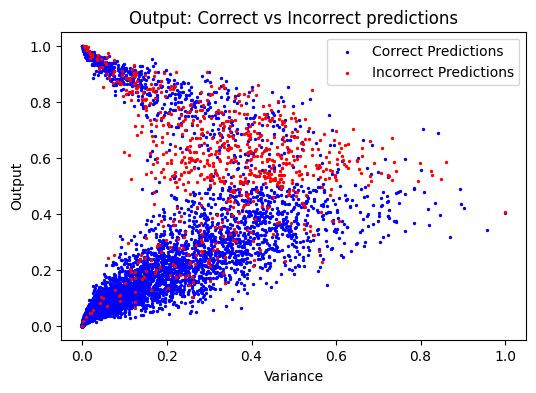

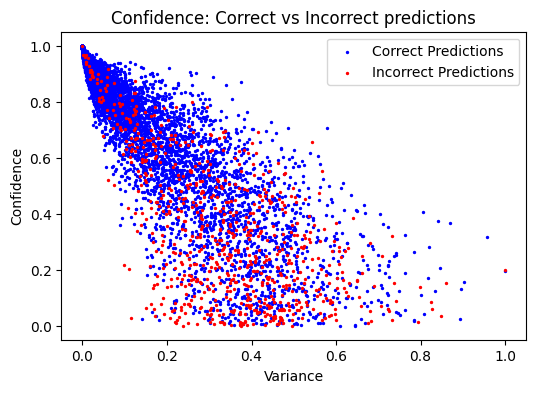

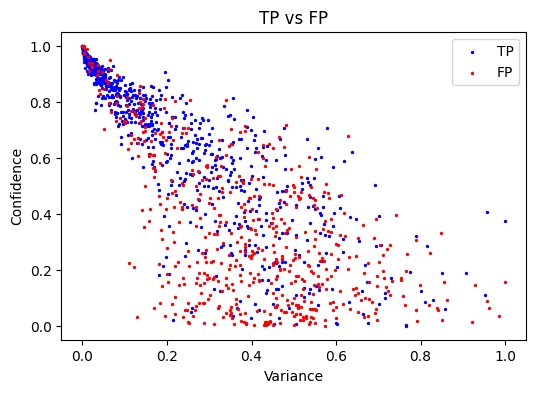

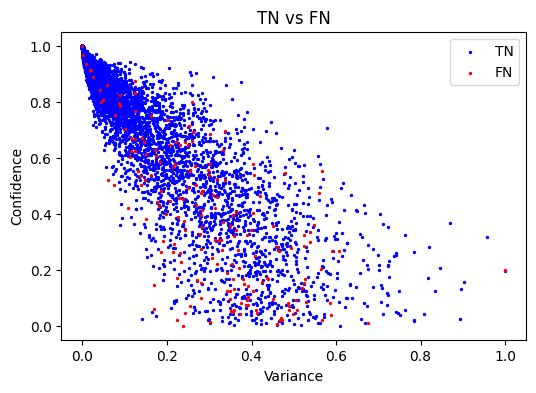

In [17]:

def normalize_and_plot(x, y, color, label=None):
    """Normalize and plot the given data."""
    # Convert to numpy for plotting

    # Normalize x and y
    x_numpy_normalized = (x - x.min()) / (x.max() - x.min())
    y_numpy_normalized = (y - y.min()) / (y.max() - y.min())

    # Plotting
    plt.scatter(x_numpy_normalized, y_numpy_normalized, color=color, label=label, s=2)
    
plt.figure(figsize=(6,4))
normalize_and_plot(var_correct, output_correct, 'blue', 'Correct Predictions')
normalize_and_plot(var_incorrect, output_incorrect, 'red', 'Incorrect Predictions')
# Add labels and legend
plt.title('Output: Correct vs Incorrect predictions')
plt.xlabel('Variance')
plt.ylabel('Output')
plt.legend()

plt.figure(figsize=(6,4))
normalize_and_plot(var_correct, conf_correct, 'blue', 'Correct Predictions')
normalize_and_plot(var_incorrect, conf_incorrect, 'red', 'Incorrect Predictions')
# Add labels and legend
plt.title('Confidence: Correct vs Incorrect predictions')
plt.xlabel('Variance')
plt.ylabel('Confidence')
plt.legend()

plt.figure(figsize=(6,4))
normalize_and_plot(var_tp, conf_tp, 'blue', 'TP')
normalize_and_plot(var_fp, conf_fp, 'red', 'FP')
plt.title('TP vs FP')
plt.xlabel('Variance')
plt.ylabel('Confidence')
plt.legend()

plt.figure(figsize=(6,4))
normalize_and_plot(var_tn, conf_tn, 'blue', 'TN')
normalize_and_plot(var_fn, conf_fn, 'red', 'FN')
plt.title('TN vs FN')
plt.xlabel('Variance')
plt.ylabel('Confidence')
plt.legend()

# Display the plot
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix

tp_count = df['tp'].sum()
tn_count = df['tn'].sum()
fp_count = df['fp'].sum()
fn_count = df['fn'].sum()


accuracy = ( tp_count + tn_count ) / ( tp_count + tn_count + fp_count + fn_count )

precision = tp_count / ( tp_count + fp_count )

recall = tp_count / ( tp_count + fn_count )

f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )

confusion = confusion_matrix(test_labels, ensemble_predictions)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.9268
Precision: 0.817
Recall: 0.5980966325036603
F1 Score: 0.6906170752324597
Confusion Matrix:
[[8451  549]
 [ 183  817]]


In [20]:

# Randomly select 50 correct and 50 incorrect predictions
true_positives = np.random.choice(true_positive_indices, 0, replace=False)
false_positives = np.random.choice(false_positive_indices, 0, replace=False)

true_negative = np.random.choice(true_negative_indices, 0, replace=False)
false_negative = np.random.choice(false_negative_indices, 16, replace=False)




# Trying to get FN predictions which have a high confidence
outputs_mean_numpy = outputs_mean
false_negative_indices_numpy = false_negative_indices

false_negative_outputs = outputs_mean_numpy[false_negative_indices_numpy].flatten()

indices = np.argsort(false_negative_outputs)

false_negative_indices_sorted_by_output = false_negative_indices_numpy[indices]
false_negative_outputs_sorted_by_output = false_negative_outputs[indices]

most_confident_outputs = false_negative_indices_sorted_by_output[-24:]





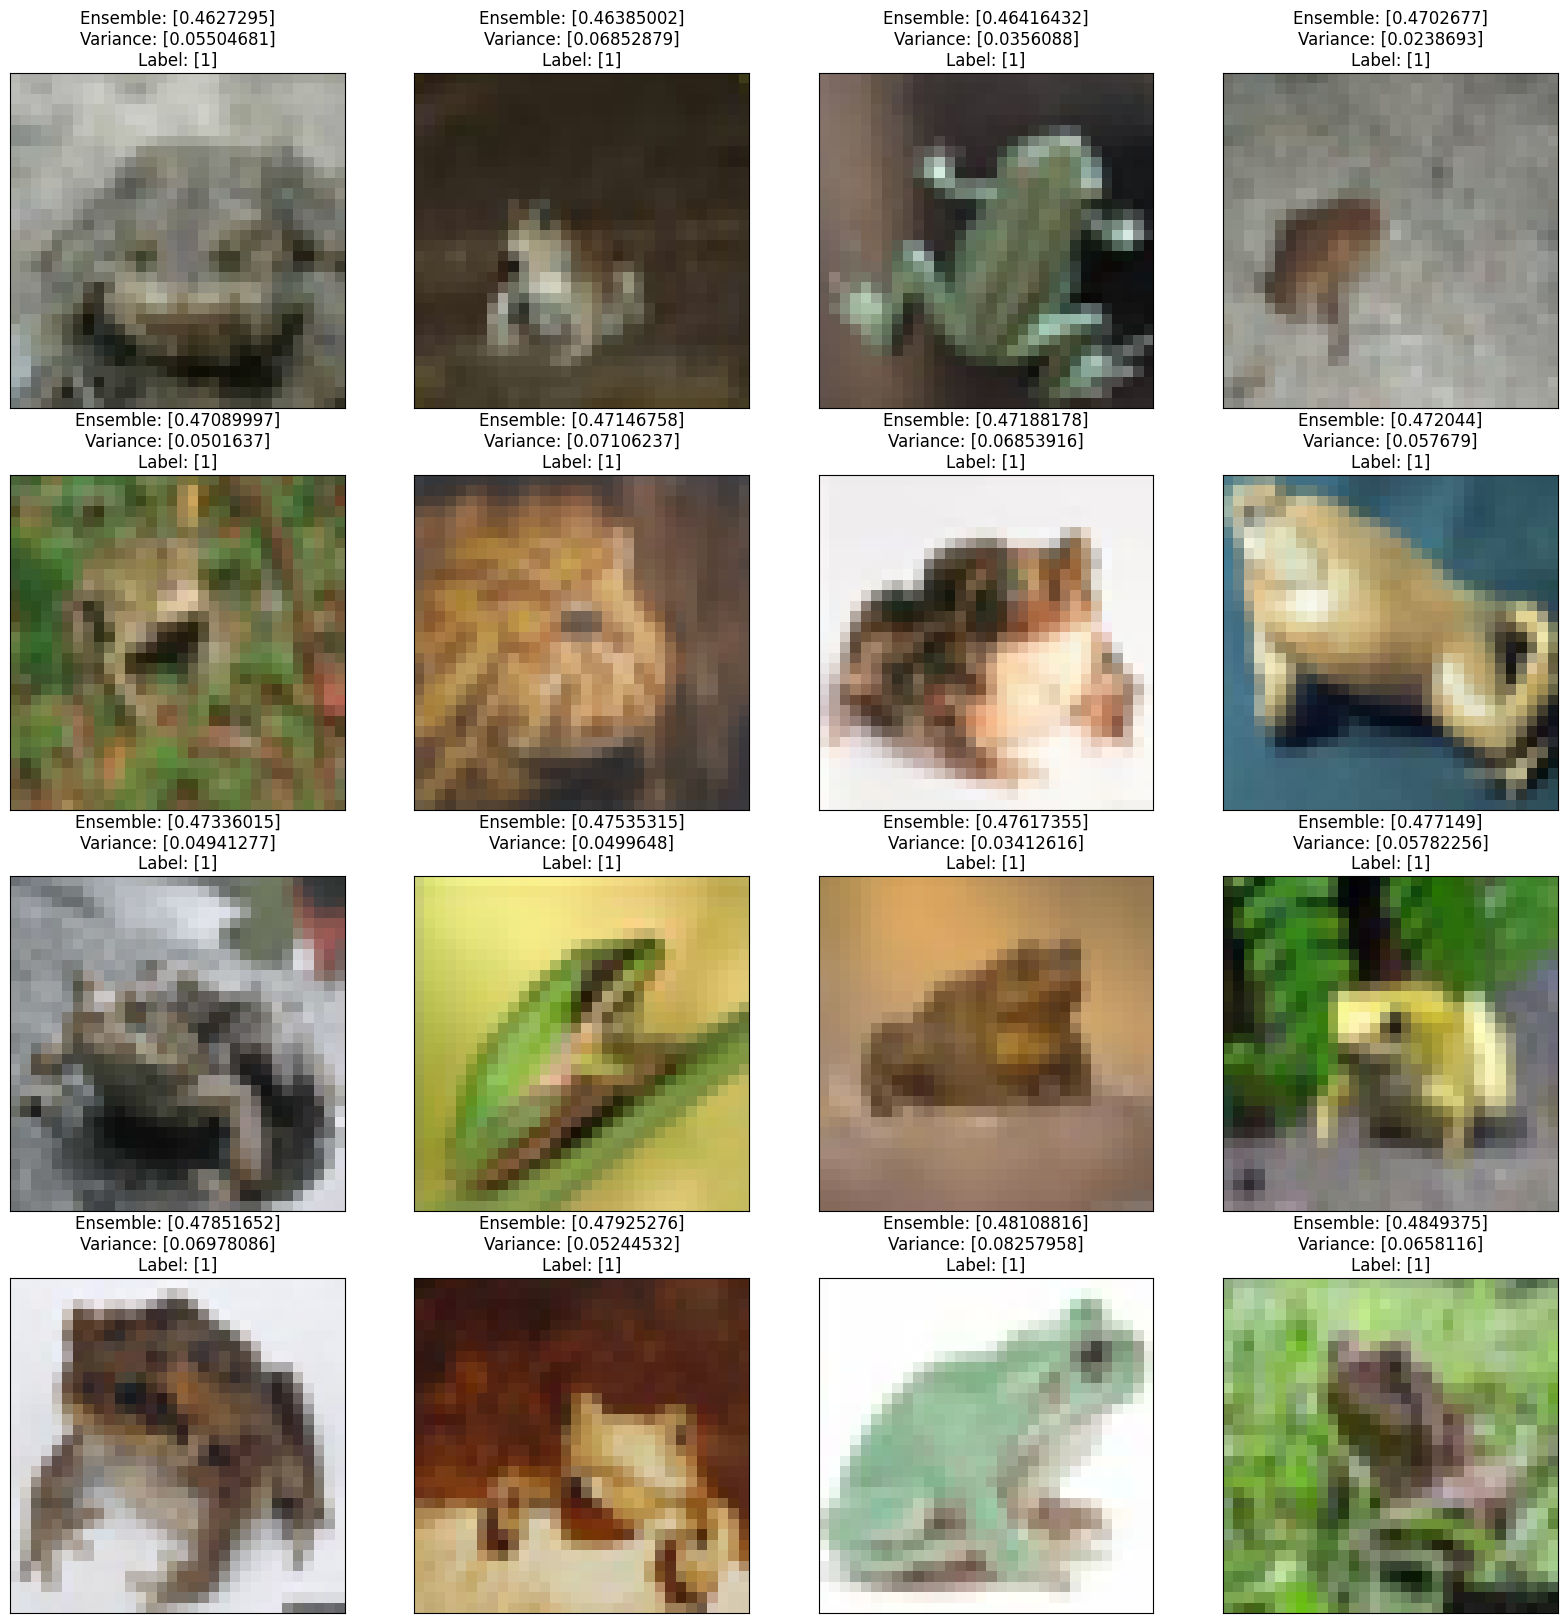

In [22]:



import matplotlib.pyplot as plt

# Create a 10x10 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    # Get the index of the current image
    index = most_confident_outputs[i]

    # Display the image
    ax.imshow(test_images[index], cmap='gray')

    # Get the predictions of the individual models and the ensemble
    # 2 x 10000 x 1
    individual_pred = outputs_stack[:, index]
    ensemble_pred = outputs_mean[index]
    ensemble_var = output_variance[index]

    # Display the predictions
    ax.set_title(f'Ensemble: {ensemble_pred}\nVariance: {ensemble_var}\nLabel: {test_labels[index]}')

    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Display the figure
plt.show()

